# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Цель: Построить модель с предельно большим значением *F1*-меры. 

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve 

import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv('/datasets/Churn.csv')

data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
#заменяем пропущенные значения в столбце на медиану, сгруппировав по возрасту

data['Tenure']=data['Tenure'].fillna(data.groupby('Age')['Tenure'].transform('median'))

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## Исследование задачи

In [4]:
data = data.drop(columns=['Surname', 'RowNumber', 'CustomerId'])

data_ohe = pd.get_dummies(data, drop_first=True)

features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

features_train1, features_valid = train_test_split(features, test_size=0.2, random_state=12345)
features_train, features_test = train_test_split(features_train1, test_size=0.25, random_state=12345)

target_train1, target_valid = train_test_split(target, test_size=0.2, random_state=12345)
target_train, target_test = train_test_split(target_train1, test_size=0.25, random_state=12345)
 
model = LogisticRegression(random_state=12345,solver='liblinear') 
model.fit(features_train,target_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [5]:
#проверка значения f1 меры на константной модели
dummy = DummyClassifier(random_state=12345)
dummy.fit(features_train, target_train)

predicted_dummy=dummy.predict(features_valid)
print(f1_score(target_valid,predicted_dummy))

0.24673784104389085


In [6]:
numeric = ['CreditScore','Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric])


print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


In [7]:
#Подбор лучших гиперпараметров для Случайного леса

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }


clf = RandomForestClassifier()
grid = GridSearchCV(clf, parametrs, cv=5,scoring='f1')
grid.fit(features_train, target_train)

print(grid.best_params_)

{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 50}


In [8]:
#Модель случайный лес

model = RandomForestClassifier(max_depth = 11,min_samples_leaf=1,min_samples_split=8,n_estimators=10)
model.fit(features_train,target_train) 
predicted_valid=model.predict(features_valid)
print(f1_score(target_valid,predicted_valid))

0.5276073619631902


In [9]:
#Подбор лучших гиперпараметров для Дерева решений

parametrs = { 'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2)}


clf = DecisionTreeClassifier()
grid = GridSearchCV(clf, parametrs, cv=5,scoring='f1')
grid.fit(features_train, target_train)

print(grid.best_params_)

{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 6}


In [10]:
#Дерево решений

model = DecisionTreeClassifier(max_depth=7,min_samples_leaf=6,min_samples_split=6)
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)
print(f1_score(target_valid,predicted_valid))

0.5557163531114326


In [11]:
#Подбор лучших гиперпараметров для Логистической регрессии

parametrs= {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf =LogisticRegression()
grid =GridSearchCV(clf,parametrs,cv=10,scoring='f1')
grid.fit(features_train, target_train)

print(grid.best_params_)

{'C': 10.0, 'penalty': 'l1'}


In [12]:
#Логистическая регрессия

model = LogisticRegression(C=10.0, penalty = 'l1')
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)
print(f1_score(target_valid,predicted_valid))

0.30366492146596863


<b> Вывод:</b> Подобрала лучшие гиперпараметры и исследовала модели - Случайного Леса, Дерева решений, Логистической регрессии.После обучения данных и без учета дисбаланса лучший результат метрики f1 был у дерева решений.</b>

In [13]:
results=pd.DataFrame({'Модель':['Константная модель','Случайный лес','Дерево решений', 'Логистическая регрессия'],
                      'F1': ['0.24', '0.56', '0.55', '0.30'],
                         }) 

print(results)

                    Модель    F1
0       Константная модель  0.24
1            Случайный лес  0.56
2           Дерево решений  0.55
3  Логистическая регрессия  0.30


## Борьба с дисбалансом

In [14]:
#Взвешивание классов

model = RandomForestClassifier(max_depth = 11,min_samples_leaf=1,min_samples_split=8,n_estimators=10, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid=model.predict(features_valid)
print(f1_score(target_valid,predicted_valid))


0.6018957345971564


In [15]:
#Увеличение выборки

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = RandomForestClassifier(max_depth = 11,min_samples_leaf=1,min_samples_split=8,n_estimators=10, class_weight='balanced')
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC", auc_roc)

F1: 0.6140724946695096
AUC-ROC 0.846214887943651


0    0.796833
1    0.203167
Name: Exited, dtype: float64


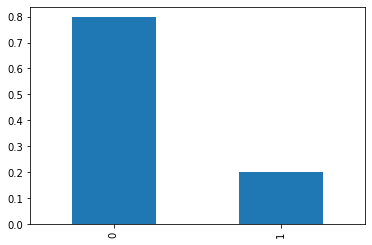

In [16]:
#считаем соотношение классов
class_frequency = target_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

In [17]:

model = RandomForestClassifier(max_depth = 11,min_samples_leaf=1,min_samples_split=8,n_estimators=10, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid,predicted_valid) 
    recall = recall_score(target_valid, predicted_valid) 

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.214, Полнота = 1.000
Порог = 0.02 | Точность = 0.218, Полнота = 0.991
Порог = 0.04 | Точность = 0.230, Полнота = 0.984
Порог = 0.06 | Точность = 0.242, Полнота = 0.979
Порог = 0.08 | Точность = 0.257, Полнота = 0.979
Порог = 0.10 | Точность = 0.270, Полнота = 0.965
Порог = 0.12 | Точность = 0.283, Полнота = 0.958
Порог = 0.14 | Точность = 0.295, Полнота = 0.941
Порог = 0.16 | Точность = 0.308, Полнота = 0.930
Порог = 0.18 | Точность = 0.325, Полнота = 0.916
Порог = 0.20 | Точность = 0.341, Полнота = 0.906
Порог = 0.22 | Точность = 0.354, Полнота = 0.888
Порог = 0.24 | Точность = 0.371, Полнота = 0.867
Порог = 0.26 | Точность = 0.386, Полнота = 0.845
Порог = 0.28 | Точность = 0.402, Полнота = 0.824
Порог = 0.30 | Точность = 0.418, Полнота = 0.808
Порог = 0.32 | Точность = 0.433, Полнота = 0.782
Порог = 0.34 | Точность = 0.447, Полнота = 0.768
Порог = 0.36 | Точность = 0.460, Полнота = 0.747
Порог = 0.38 | Точность = 0.477, Полнота = 0.728
Порог = 0.40 | Точно

In [18]:
model = RandomForestClassifier(max_depth = 11,min_samples_leaf=1,min_samples_split=8,n_estimators=10, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > 0.51
recall = recall_score(target_valid, predicted_valid) 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("Полнота = {:.3f}".format(recall))
print("F1:", f1_score(target_valid, predicted_valid))
print("AUC-ROC", auc_roc)

Полнота = 0.611
F1: 0.6192170818505337
AUC-ROC 0.8465372183703034


<b> Вывод:</b> Был учтен дисбаланс, для этого применены следующие способы борьбы с дисбалансом:

1.Взвешивание классов, после чего мера f1 повысилась до 0.57

2.Увеличение выборки, после чего мера f1 повысилась до 0.58

3.Изменение порога классификации, после чего мера f1 повысилсь до 0.60

метрика AUC-ROC при этом равна 0.81, что близко к 1, и лучше, чем AUC-ROC случайной модели(0.5)

In [19]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model = RandomForestClassifier(max_depth = 11,min_samples_leaf=1,min_samples_split=8,n_estimators=10, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)


print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5727109515260324


## Тестирование модели

In [20]:
features_new = pd.concat([features_train] + [features_valid])
target_new = pd.concat([target_train] + [target_valid])

class_frequency = target_new.value_counts(normalize=True)
print(class_frequency)

print(features_new.shape)
print(target_new.shape)

0    0.79425
1    0.20575
Name: Exited, dtype: float64
(8000, 11)
(8000,)


In [21]:
def upsample(features, target, repeat):
    features_zeros = features_new[target == 0]
    features_ones = features_new[target == 1]
    target_zeros = target_new[target == 0]
    target_ones = target_new[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_new, target_new, 4)

model = RandomForestClassifier(max_depth = 11,min_samples_leaf=1,min_samples_split=8,n_estimators=10, class_weight='balanced')
model.fit(features_upsampled,target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=8, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [37]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > 0.56
recall = recall_score(target_test, predicted_test) 
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("F1:", f1_score(target_test, predicted_test))
print("AUC-ROC", auc_roc)

F1: 0.5945945945945946
AUC-ROC 0.8427229188754433


<b> Вывод:</b> Проведено тестирование на обученной модели с учетом дисбаланса.
Доля правильных ответов равна 0.762, что показывает хороший результат

In [38]:
#сравнение с константной моделью
dummy = DummyClassifier(random_state=12345)
dummy.fit(features_new, target_new)

predicted_dummy=dummy.predict(features_test)
print(f1_score(target_test,predicted_dummy))

0.20024721878862797


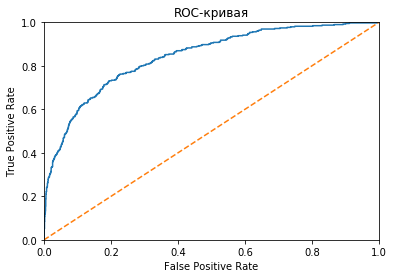

In [39]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 


Вывод:
    
В ходе работы были изучены данные и отобраны параметры для обучения модели. Все данные были поделены на 3 выборки - тренировочную, валидационную и тестовую в соотношении - 60%, 20%, 20%. Произведена OHE и нормировка данных. Изучены три модели без учета дисбаланса классов - Дерево решений, Случайный лес, Логистическая регрессия. Для каждой модели подобраны параметры методом GridSearchCV. Сравнила значение f1 мер у всех моделей с константной моделью:

 


In [26]:
print(results)

                    Модель    F1
0       Константная модель  0.24
1            Случайный лес  0.56
2           Дерево решений  0.55
3  Логистическая регрессия  0.30



Далее был учтен дисбаланс классов и пременены способы борьбы с ним:
1.Взвешивание классов
2.Увеличение выборки
3.Уменьшение выборки
4.Изменение порога
    
После чего у лучшей модели значение меры f1 после обучения на тренировочной выборке =  0.61, а AUC-ROC 0.8.
Далее было проведено тестирование модели на тестовых данных, предварительно обучив модель на полных данных ( тренировочные + валидационные). Построен график Roc-кривой в сравнении с кривой константной модели. Значение f1 меры на тестовой выборке = 0.59, AUC-ROC 0.84.

 